In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


from estimator_model.deepiv import Net, NetWrapper, DeepIV, MixtureDensityNetwork, MDNWrapper
from estimator_model.utils import BatchData, DiscreteOBatchData

## We divide this notebook into 3 sections, where we
1. ### test Net and NetWrapper in the first section
2. ### test MDN and MDNWrapper in the second section
3. ### test deepiv in the final section.

### Section 1

- continuous input, continuous output

In [2]:
net = Net(x_d=1, w_d=1, out_d=1)
net_wrapped = NetWrapper(net, is_y_net=False)
x = torch.normal(0, 1, size=(1000, 1))
w = torch.ones(1000, 1)

def f(x, w):
    return x * x + torch.exp(x) + 3 * w

target = f(x, w)

net_wrapped.fit(
    x=x,
    w=w,
    target=target,
    device='cpu',
    epoch=10,
)
((net_wrapped.predict(x, w) - f(x, w)) / f(x, w)).mean(dim=0)

Finished 1/10 epochs | current loss 1.4168747663497925
Finished 2/10 epochs | current loss 0.7672350406646729
Finished 3/10 epochs | current loss 0.7138416767120361
Finished 4/10 epochs | current loss 0.6304697394371033
Finished 5/10 epochs | current loss 0.4455448091030121
Finished 6/10 epochs | current loss 0.6301072835922241
Finished 7/10 epochs | current loss 0.5874323844909668
Finished 8/10 epochs | current loss 0.4888414442539215
Finished 9/10 epochs | current loss 0.4021173417568207
Finished 10/10 epochs | current loss 0.33288058638572693


tensor([-0.0966], grad_fn=<MeanBackward1>)

- contiuous input, discrete output

In [3]:
out_d = 5
net = Net(x_d=1, w_d=1, out_d=out_d, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
result = sm(net(torch.ones(5, 1), torch.randn(5, 1)))
l = loss(result, torch.eye(5, 5))
l.backward()

In [4]:
x = torch.normal(0, 1, size=(1000, 1))
w = torch.normal(1, 2, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(1, 1, 2, is_discrete_output=True)
net_wrapped = NetWrapper(net=net, is_y_net=False)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=20)
# training loss
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 1/20 epochs | current loss 0.5196241140365601
Finished 2/20 epochs | current loss 0.41504520177841187
Finished 3/20 epochs | current loss 0.33952856063842773
Finished 4/20 epochs | current loss 0.28176793456077576
Finished 5/20 epochs | current loss 0.2374466210603714
Finished 6/20 epochs | current loss 0.20354294776916504
Finished 7/20 epochs | current loss 0.1771501749753952
Finished 8/20 epochs | current loss 0.15626473724842072
Finished 9/20 epochs | current loss 0.13959136605262756
Finished 10/20 epochs | current loss 0.126083642244339
Finished 11/20 epochs | current loss 0.11498582363128662
Finished 12/20 epochs | current loss 0.10568921267986298
Finished 13/20 epochs | current loss 0.09783084690570831
Finished 14/20 epochs | current loss 0.09112057834863663
Finished 15/20 epochs | current loss 0.08530230820178986
Finished 16/20 epochs | current loss 0.08023881912231445
Finished 17/20 epochs | current loss 0.0758025273680687
Finished 18/20 epochs | current loss 0.0718559

tensor(5.4983, grad_fn=<NllLossBackward0>)

- discrete input, discret output

In [5]:
net = Net(x_d=3, w_d=1, out_d=5, is_discrete_input=True, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.eye(5, 5))
l.backward()

In [6]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 1, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=2, is_discrete_output=True, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=10)
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 1/10 epochs | current loss 0.6673639416694641
Finished 2/10 epochs | current loss 0.6112226843833923
Finished 3/10 epochs | current loss 0.557029664516449
Finished 4/10 epochs | current loss 0.5023502707481384
Finished 5/10 epochs | current loss 0.4469907879829407
Finished 6/10 epochs | current loss 0.39333924651145935
Finished 7/10 epochs | current loss 0.3435899615287781
Finished 8/10 epochs | current loss 0.2993813753128052
Finished 9/10 epochs | current loss 0.2614312171936035
Finished 10/10 epochs | current loss 0.2295801192522049


tensor(0.7294, grad_fn=<NllLossBackward0>)

- discrete input, continuous output

In [7]:
net = Net(x_d=3, w_d=1, out_d=1, is_discrete_input=True, is_discrete_output=False)
sm = nn.Softmax(dim=1)
loss = nn.MSELoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.ones(5, 1))
l.backward()

In [8]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 2, size=(1000, 1))

def f(x, w):
    weight = torch.normal(0, 1, size=(6, 1))
    xw = torch.cat((x, w), dim=1)
    target = torch.einsum('nd,dc->nc', [xw, weight])
    return target

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=1, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x=x, w=w, target=target, device='cpu', epoch=10)
nn.MSELoss()(net_wrapped.predict(x=x, w=w), target)

Finished 1/10 epochs | current loss 0.9778620600700378
Finished 2/10 epochs | current loss 0.18882359564304352
Finished 3/10 epochs | current loss 0.10571161657571793
Finished 4/10 epochs | current loss 0.06292218714952469
Finished 5/10 epochs | current loss 0.03989410400390625
Finished 6/10 epochs | current loss 0.026483479887247086
Finished 7/10 epochs | current loss 0.01816629432141781
Finished 8/10 epochs | current loss 0.01276762317866087
Finished 9/10 epochs | current loss 0.009174221195280552
Finished 10/10 epochs | current loss 0.006704655475914478


tensor(0.0070, grad_fn=<MseLossBackward0>)

### Section 2

Test the MDN and MDNWrapper

In [9]:
z_d = 3
w_d = 2
out_d = 1
num_gaussian = 10
mdn = MixtureDensityNetwork(
    z_d=z_d,
    w_d=w_d,
    out_d=out_d,
    num_gaussian=num_gaussian,
    is_discrete_input=False,
)
mdn_wrapped = MDNWrapper(mdn=mdn)

In [10]:
n = 200
z = torch.normal(1, 2, size=(n, z_d))
w = torch.normal(0, 1, size=(n, w_d))
zw = torch.cat((z, w), dim=1)
weight = torch.normal(1, 2, size=(zw.shape[1], 1))
target = torch.distributions.Poisson(torch.exp(zw.matmul(weight))).sample()

In [11]:
# mdn_wrapped.fit(
#     z=z,
#     w=w,
#     target=target,
#     device='cpu',
#     lr=0.2,
#     batch_size=20,
#     epoch=2,
# )

In [12]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n, 1))
w = np.random.uniform(low=0.0, high=10.0, size=(n, 1))
z = np.random.uniform(low=0.0, high=10.0, size=(n, 1))

e, w, z = torch.tensor(e), torch.tensor(w), torch.tensor(z)
weight_w = torch.randn(1)
weight_z = torch.randn(1)

def treatment(w, z, e):
    x = torch.sqrt(w) * weight_w + torch.sqrt(z) * weight_z + e
    x = (torch.sign(x) + 1) /  2
    return F.one_hot(x.reshape(-1).to(int))

In [13]:
# Outcome equation 
weight_x = torch.randn(2, 1)
weight_wx = torch.randn(2, 1)
def outcome(w, e, treatment):
    wx = torch.mm(treatment.to(torch.float32), weight_x)
    wx1 = (w * treatment.to(torch.float32)).to(torch.float32).matmul(weight_wx.to(torch.float32))
    # wx1 = w
    return (wx**2) * 10 - wx1 + e / 2
treatment = treatment(w, z, e)
y = outcome(w, e, treatment)

In [14]:
data_dict = {
    'z': z.squeeze().to(torch.float32),
    'w': w.squeeze().to(torch.float32),
    'x': torch.argmax(treatment, dim=1),
    'y': y.squeeze().to(torch.float32)
}
data = pd.DataFrame(data_dict)
data.head()

,z,w,x,y
0,5.671995,1.768527,0,7.932928
1,9.485405,3.200217,0,6.899121
2,2.241611,0.230992,0,8.826457
3,5.771337,1.093724,1,5.835914
4,8.596682,6.167256,0,5.319467


In [15]:
iv = DeepIV(is_discrete_treatment=True)
iv.fit(
    data=data,
    outcome='y',
    treatment='x',
    instrument='z',
    adjustment='w',
    device='cpu',
    batch_size=2500,
    lr=0.5,
    epoch=1,
)

Finished 1/1 epochs | current loss 1.2706555128097534
Finished 1/1 epochs | current loss 3944774.75


In [16]:
hasattr(iv, 'x_net')

True

In [17]:
iv.estimate()

tensor([1.5379e+20], grad_fn=<MeanBackward1>)

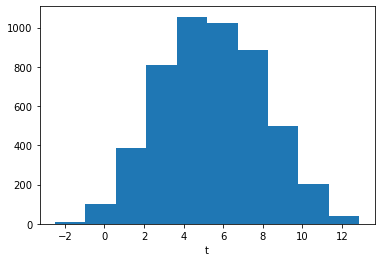

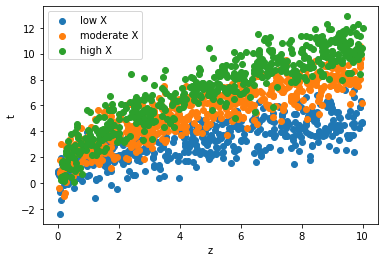

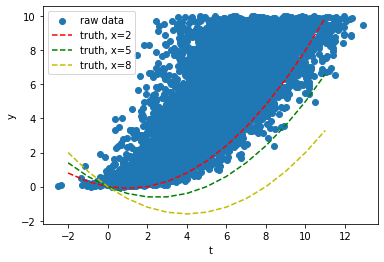

In [18]:
n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n,))
x = np.random.uniform(low=0.0, high=10.0, size=(n,))
z = np.random.uniform(low=0.0, high=10.0, size=(n,))

# Initialize treatment variable
t = np.sqrt((x+2) * z) + e

# Show the marginal distribution of t
plt.hist(t)
plt.xlabel("t")
plt.show()

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.xlabel("z")
plt.ylabel("t")
plt.show()

# Outcome equation 
y = t*t / 10 - x*t / 10 + e

# The endogeneity problem is clear, the latent error enters both treatment and outcome equally
plt.scatter(t,z, label ='raw data')
tticks = np.arange(-2,12)
yticks2 = tticks*tticks/10 - 0.2 * tticks
yticks5 = tticks*tticks/10 - 0.5 * tticks
yticks8 = tticks*tticks/10 - 0.8 * tticks
plt.plot(tticks,yticks2, 'r--', label = 'truth, x=2')
plt.plot(tticks,yticks5, 'g--', label = 'truth, x=5')
plt.plot(tticks,yticks8, 'y--', label = 'truth, x=8')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [19]:
import pandas as pd
from estimator_model.utils import convert2tensor
z, w, x, y = convert2tensor(z, x, t, y)
z = z.squeeze().to(torch.float32)
w = w.squeeze().to(torch.float32)
x = x.squeeze().to(torch.float32)
y = y.squeeze().to(torch.float32)

data_dict = {
    'z': z,
    'w': x,
    'x': t,
    'y': y
}
data = pd.DataFrame(data_dict)

In [20]:
iv = DeepIV(num_gaussian=10)
iv.fit(
    data=data,
    outcome='y',
    treatment='x',
    instrument='z',
    adjustment='w',
    sample_n=2,
    lr=0.5,
    epoch=1,
    device='cpu',
    batch_size=5000
)

Finished 1/1 epochs | current loss -4.673593551906384
Finished 1/1 epochs | current loss 147222265856.0


In [21]:
iv.estimate()

tensor([nan], grad_fn=<MeanBackward1>)